# The goal of this exercise is to find the best place to open a yoga studio in the Sacramento County, California, USA.


The selection will be based on the population of the neighbourhood, average age, median income and the number of nearby fitnes centers.

To this end, K-Means clustering analyis will be performed in the socio-econimic database to identify the zipcodes with relatively high population with high medain income. By the use of the FourSquare data, the distriubution of the yoga studios and the gym/fitness centers will be identified. Here, an assumption is made that the gym/fitness centers also has yoga classes. This assumption is based on general observation. Superimpostion of the two information will enable the identificaiton of the best area in the Sacramento County to open a yoga studio. 

This work is divided into 3 parts:

Part I: extraction of socio-economic data of different zipcodes in the Sacramento County.

Part II: K-Means clustering of socio-economic data to find a cluster of zipcodes with best potential.

Part III: Extracting venue information from FourSquare to find the total of yoga centers,gym and fitness centers in each  zipcodes of the best cluster determined in part II. 

The best zipcode to open a yoga studio will be determined using the information from part II and III. 

## Part I-Extraction of Socio-Economic Data by Web Scrapping

All the zipcodes in the Sacramento County along with the information about their population, average age, medain income, and median home price can be found in the following website:

https://www.bestplaces.net/find/zip.aspx?st=CA&county=06067


The first step is to scrap the data using the BeautifulSoup module.

Lets import the necessary libraries

In [3]:
from bs4 import BeautifulSoup #library for web scrapping 
import urllib.request
import pandas as pd
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

Following are some functions that are necessary to clean the web-scrapped data

In [4]:
#This function returns the value of zipcode and city from string of type '95831 (Sacramento)'
#In the above example, zipcode=95831 and city=Sacramento
def returnZip(t):
    t2=t.split(' ')
    zipcode=t2[0]
    #get string inside parenthesis
    t3=t2[1].split('(')
    t4=t3[1].split(')')
    area=t4[0].lower()    
    loc=[zipcode,area]
    return loc

In [5]:
#Function test:
t='95831 (Sacramento)'
returnZip(t)

['95831', 'sacramento']

In [7]:
#Changing the string of the format '$50,000' to integer 50000
def dollar2num(t):
    t1=t.split('$')
    t2=t1[1].split(',')
    t3=''
    for f in t2:
        t3=t3+f
    num=int(t3)
    return num

In [10]:
#Function test:
t='$10,000'
dollar2num(t)

10000

In [9]:
#changing the string of the format '50,000' to integer 50000
def string2num(t):  
    t2=t.split(',')
    t3=''
    for f in t2:
        t3=t3+f
    num=int(t3)
    return num

In [11]:
#Function test:
t='80,000'
string2num(t)


80000

The foloowing figure is the screen-shot of the website mentioned earlier: https://www.bestplaces.net/find/zip.aspx?st=CA&county=06067

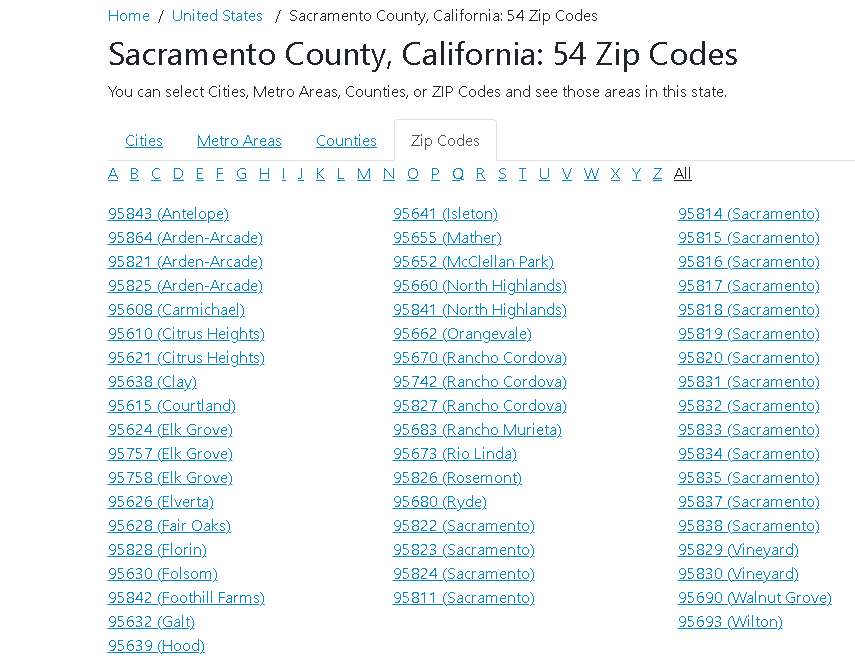

Each zipcode link needs to be clicked to see the information about the population, medain income,age and home pirce.

After clicking the first link, i.e 95843 (Antelope), we are taken to the address of the form:
https://www.bestplaces.net/zip-code/california/antelope/95843

The follwoing function will extract information from the location given in the form ['95843','Antelope']

In [12]:
def socioEconomicData(location):
    #Gathers socio-economic data from each zipcodes of sacramento county and stores in pandas data frame
    url2='https://www.bestplaces.net/zip-code/california/'+location[1]+'/'+location[0]    
    html2 = urllib.request.urlopen(url2).read()
    soup2 = BeautifulSoup(html2,features="lxml")    
    data2=list(soup2.find_all(class_='col-md-3 px-1'))#contains info about populaton, median income and median house price and median age
    population=[data2[0].find('p',class_="text-center py-0 my-0").get_text()]#population of the zipcode
    economicData=list(data2[1].find_all(class_='text-center'))
    ageData=list(data2[2].find_all(class_='text-center'))
    
    num_medianIncome=[economicData[1].get_text()]# value of Medain Income
    num_medianHomePrice=[economicData[3].get_text()]#value of Medain Home Income
    str_medianAge=ageData[0].get_text() #text 'Medain Age'
    num_medianAge=[ageData[1].get_text()] #value of 'Median Age'
    dataDic={'Zipcode':[location[0]],'City':[location[1]],'Population':population,str_medianAge:num_medianAge,'Median Income(US$)':num_medianIncome,'Median Home Price(US$)':num_medianHomePrice}
    df=pd.DataFrame.from_dict(dataDic)
    return df

In [13]:
#Test of the function:
location=['95843','Antelope']
df_test=socioEconomicData(location)
df_test

,Zipcode,City,Population,Median Age,Median Income(US$),Median Home Price(US$)
0,95843,Antelope,"47,088",33.6,"$64,773","$353,600"


The following piece of code will loop throung all the zipcodes of the main page and extract the socio-economic data using the above function.

In [35]:
#Scrap zipcodes in Sacramento county with population, medain income and house price
url='https://www.bestplaces.net/find/zip.aspx?st=CA&county=06067'
html = urllib.request.urlopen(url).read()
soup = BeautifulSoup(html,features="lxml")
data1=list(soup.find_all(class_='col-md-4'))#The zip codes are stored in columns, one such column belongs to class 'col-md-4'
#Using print(data1.prettify()), it was found that the zip code and the area names are stored in in tag 'u'

header=['Zipcode','City','Population','Median Age','Median Income(US$)','Median Home Price(US$)'] #Column names for 
dataEconomic=pd.DataFrame(columns=header) #dataframe for storing the scrapped information
for tag in data1:
    data2=tag.find_all('u')    
    for d in data2:   
        zipInfo=d.get_text()
        location=returnZip(zipInfo)
        df=socioEconomicData(location)
        dataEconomic=dataEconomic.append(df,ignore_index=True)
        
#Changing strings  into integer numbers using the funtions given at the begining.
dataEconomic['Median Income(US$)']=dataEconomic['Median Income(US$)'].apply(lambda x: dollar2num(x))
dataEconomic['Median Home Price(US$)']=dataEconomic['Median Home Price(US$)'].apply(lambda x: dollar2num(x))
dataEconomic['Median Age']=dataEconomic['Median Age'].apply(lambda x: float(x))
dataEconomic['Population']=dataEconomic['Population'].apply(lambda x: string2num(x))

In [36]:
dataEconomic.head()

,Zipcode,City,Population,Median Age,Median Income(US$),Median Home Price(US$)
0,95843,antelope,47088,33.6,64773,353600
1,95864,arden-arcade,23458,46.9,83467,577100
2,95821,arden-arcade,35734,38.0,38777,354600
3,95825,arden-arcade,34201,31.8,37382,313000
4,95608,carmichael,61365,43.4,55256,410400


We are mising the information about the latitude and the longitude of each zipcode. These information can be found in the following website:
https://geo.nyu.edu/catalog/stanford-cm480wn0393


The GeoJSON file given in the website was downloaded and the latitude and lognitude information for each zipcode was extraced from it using the following piece of code.

In [37]:
#Getting information about the lattitude and longitude for each zipcode
with open(r'C:\Users\Sudeep\Dropbox\Online Classes\Data Science Course\Capstone Project\SacramentoZipCodes-geojson.json') as json_data:
    Sac_data = json.load(json_data) #zip codes of all locations are in key 'features'

features=Sac_data['features']
header2=['Zipcode','Location','Longitude','Latitude']
dataLocation=pd.DataFrame(columns=header2)
#start loop here
for prop in features:    
    zipcodeInfo=prop['properties'] #dictionary with zipcode and location name
    coordinates=zipcodeInfo['bbox'] #it has two sets of coordinates, possiblly the endpoints of the area in the zipcode
    latLong=[(coordinates[0]+coordinates[2])/2,(coordinates[1]+coordinates[3])/2] #middle of two coordinates given above
    zipcode=[zipcodeInfo['zip5']]
    loc=[zipcodeInfo['po_name']] #name of city
    long=[latLong[0]] #longtitude of the zipcode
    lat=[latLong[1]] #latitude of the zipcode
    locInfo=[zipcode,loc,long,lat]
    z=zip(header2,locInfo)
    zipDict=dict(z)
    dfloc=pd.DataFrame.from_dict(zipDict)
    dataLocation=dataLocation.append(dfloc,ignore_index=True)


In [38]:
dataLocation.head()

,Zipcode,Location,Longitude,Latitude
0,95680,RYDE,-121.557800,38.234229
1,95671,REPRESA,-121.156851,38.693320
2,95670,RANCHO CORDOVA,-121.262623,38.609066
3,95655,MATHER,-121.282143,38.549707
4,95824,SACRAMENTO,-121.440891,38.510470


In [39]:
#Getting latitude and longitude information from dataLocation and adding it to dataEconomic    
dataLocation=dataLocation.set_index(['Zipcode'])
mask=dataEconomic['Zipcode']
latLongData=dataLocation.loc[mask]
latLongData=latLongData.reset_index() 
#latLongData dataframe is a restructured version of dataLocation. 
#It has same number of zipcodes as in dataEconomic and they are arranged in the same order.
dataEconomic['Longitude']=latLongData['Longitude']
dataEconomic['Latitude']=latLongData['Latitude']

In [40]:
dataEconomic.head()

,Zipcode,City,Population,Median Age,Median Income(US$),Median Home Price(US$),Longitude,Latitude
0,95843,antelope,47088,33.6,64773,353600,-121.360957,38.715001
1,95864,arden-arcade,23458,46.9,83467,577100,-121.375911,38.585289
2,95821,arden-arcade,35734,38.0,38777,354600,-121.383362,38.625708
3,95825,arden-arcade,34201,31.8,37382,313000,-121.400280,38.585179
4,95608,carmichael,61365,43.4,55256,410400,-121.324950,38.626384


## Part II-Running K-Means Clustering on dataEconomic

All the non essential information, such as City, Longtitude and Latitude will be dropped. The remaning data will be standardized beacuse they are not at the same scale. 

Also, it was noticed that one of the cities, Ryde, had very samll population of less than 100 and its median inocme was given as zero. It may interfer with the analysis so that particular city was dropped. 

In [41]:
dataEconomic =dataEconomic[dataEconomic['Median Income(US$)'] != 0] 
X = dataEconomic.drop(['Zipcode','City','Latitude','Longitude'],axis=1)#droping non essential information
from sklearn.preprocessing import StandardScaler
sac_grouped_clustering = StandardScaler().fit_transform(X) #standarization of dataset

The next step is to identify the best number of clusters. For this purpose, the 'elbow' method was used.

Text(0, 0.5, 'Distortion')

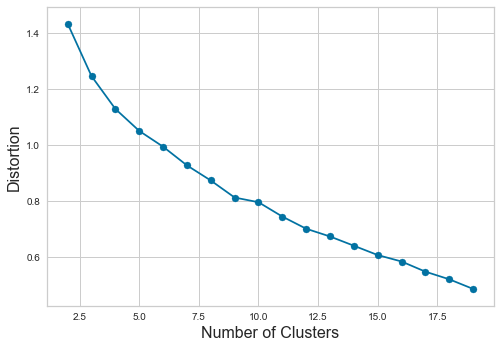

In [42]:
#Determining the optimum cluster number by elbow method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
counter=[]
dis=[]#empty array to store distortion
from scipy.spatial.distance import cdist 
for kclusters in range(2,20):
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sac_grouped_clustering)   
    dis.append(sum(np.min(cdist(sac_grouped_clustering, kmeans.cluster_centers_,'euclidean'),axis=1)) /sac_grouped_clustering.shape[0])  
    counter.append(kclusters)
plt.figure(1)
plt.scatter(counter,dis)
plt.plot(counter,dis)
plt.xlabel('Number of Clusters',fontsize=16)
plt.ylabel('Distortion',fontsize=16)

The 'elbow' in th above plot is not apparent. A library name 'yellowbrick' was used to find the elbow. 
The information about the library can be found in https://www.scikit-yb.org/en/latest/

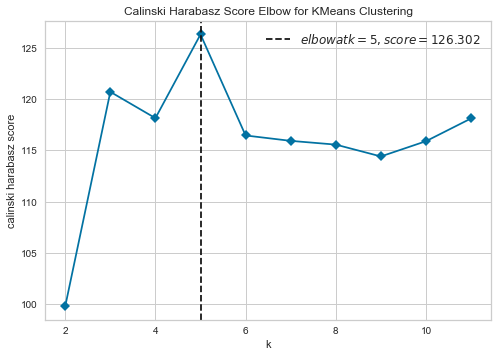

In [43]:
kmeans = KMeans()
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(kmeans, k=(2,12), metric='calinski_harabasz', timings=False) #for determining elbow

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

The above analyses shows that the optimum cluster number is 5

Runnig K-Means with cluster number=5

In [44]:
kclusters =5 #determined from elbow method
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sac_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
# add clustering labels
dataEconomic.insert(0, 'Cluster Labels', kmeans.labels_)#adding labels to dataEconomic
groupedData=dataEconomic.groupby('Cluster Labels')#grouping dataEconomic according to cluster label

To get better insight about each cluster, population,age,income and home prices will be averaged for each cluster and plotted.

In [47]:
head=['Cluster','Average Population','Average Age','Average Income','Average Home Price']
avgDf=pd.DataFrame(columns=head) #empty dataframe to hold average values for each cluster
for c in range(0,kclusters):
    Cluster=c
    avgPop=groupedData.get_group(c).describe().loc['mean','Population']
    avgAge=groupedData.get_group(c).describe().loc['mean','Median Age']
    avgIncome=groupedData.get_group(c).describe().loc['mean','Median Income(US$)']
    avgHomePrice=groupedData.get_group(c).describe().loc['mean','Median Home Price(US$)']
    dataDict={'Cluster':[Cluster],'Average Population':[avgPop],'Average Age':[avgAge],'Average Income':[avgIncome],'Average Home Price':[avgHomePrice]}
    dfMean=pd.DataFrame.from_dict(dataDict)
    avgDf=avgDf.append(dfMean,ignore_index=True)
avgDf.set_index(['Cluster'],inplace=True)

In [48]:
#Normalizing all the columns to 100 so that they can be visualized on the same scale
avgDf['Average Population']=avgDf['Average Population']/avgDf['Average Population'].max()*100
avgDf['Average Age']=avgDf['Average Age']/avgDf['Average Age'].max()*100
avgDf['Average Income']=avgDf['Average Income']/avgDf['Average Income'].max()*100
avgDf['Average Home Price']=avgDf['Average Home Price']/avgDf['Average Home Price'].max()*100

In [76]:
avgDf.head()

,Average Population,Average Age,Average Income,Average Home Price
Cluster,,,,
0,78.778193,67.953627,56.376584,52.124399
1,9.792645,100.000000,100.000000,100.000000
2,19.152519,74.022716,54.387279,58.211608
3,100.000000,80.057981,92.314688,74.613966
4,31.979972,71.951831,94.583521,85.717101


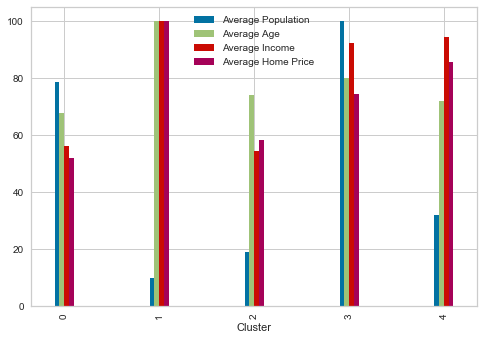

In [49]:
#Plotting the average vlaues of each iteam for all the clusters
avgDf.plot.bar(width=0.2)

In [51]:
#lets look at the socio-economic data for cluster 3
groupedData.get_group(3).describe()

,Cluster Labels,Population,Median Age,Median Income(US$),Median Home Price(US$),Longitude,Latitude
count,9.0,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,3.0,52037.777778,39.888889,75619.000000,441733.333333,-121.349823,38.544861
std,0.0,15019.954725,3.981973,13299.151383,52879.414709,0.139555,0.137727
min,3.0,31738.000000,34.700000,55256.000000,390800.000000,-121.531206,38.342434
25%,3.0,40882.000000,36.600000,68679.000000,400900.000000,-121.449334,38.431007
50%,3.0,48242.000000,40.900000,72739.000000,435900.000000,-121.324950,38.626384
75%,3.0,63977.000000,43.400000,80449.000000,452800.000000,-121.252645,38.651726
max,3.0,75864.000000,45.500000,100308.000000,554200.000000,-121.125443,38.686473


The above figure is very insightful and shows that the best zipcodes for opening yoga studios are in cluster 3. This cluster has the highest population, with median age below 45 (determined by inspecting the data frame), and second highest median income. 

Producing the cluser map using Folium

In [58]:
import matplotlib.cm as cm
import matplotlib.colors as colors
#Creating map of Sacramento
address = 'Sacramento'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map reflecting the clusters of zipcodes
markers_colors = []
for lat, lon, poi, cluster in zip(dataEconomic['Latitude'], dataEconomic['Longitude'], dataEconomic['Zipcode'], dataEconomic['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [59]:
map_clusters

## Part III-Finding the locations of gym/fitness centers and yoga studios in the Sacramento County using FourSquare

In [60]:
#Define Foursquare Credentials and Version
CLIENT_ID = '2VJ2GRSI0CC0IIFLJLU1REFSOHKV01X5BQCORQC0YLSXNUT1' # your Foursquare ID
CLIENT_SECRET = '445JKD5IYV05AFKJLJNP1YZFVACV2QUAQA1ZS2YRPJW0J0DJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [64]:
#Getting venue within 5 kilometers/3.11 miles of  each zipcodes in dataEconomic. 
#The large radius is necessary because thearea occupied by a zipcode is pretty large. 
#The area occupied by zipcodes and hence the choice of the readius was verified by using googel map. 
import requests
def getNearbyVenues(names, latitudes, longitudes,LIMIT=200,radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    
sac_venues = getNearbyVenues(names=dataEconomic['Zipcode'],
                                   latitudes=dataEconomic['Latitude'],
                                   longitudes=dataEconomic['Longitude'])

In [65]:
sac_venues.head()

,Zipcode,Zipcode Latitude,Zipcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,95843,38.715001,-121.360957,Panda Express,38.714172,-121.367054,Chinese Restaurant
1,95843,38.715001,-121.360957,Dry Creek Community Park,38.729149,-121.361079,Park
2,95843,38.715001,-121.360957,Yogurt Time Cafe,38.711394,-121.366032,Ice Cream Shop
3,95843,38.715001,-121.360957,Papa Murphy's,38.712452,-121.363500,Pizza Place
4,95843,38.715001,-121.360957,La Belle Nails,38.714177,-121.367275,Cosmetics Shop


The next job is to find the total number of gym/fitness centers or yoga studios in the zipcodes of cluster 3 of output 49

The following code will give a dataframe with zipcodes in one column and total number of yoga studios+gym+fitness centers in the second column

In [66]:
def zeroOneEncoding(venuCat):
    # Returns 1 if venu category=Gym or Gym/Fitness or Yoga Studio 
    #Returns 0 for all other cases
    if venuCat=='Gym' or venuCat=='Gym / Fitness Center' or venuCat=='Yoga Studio':
        return 1
    else:
        return 0

sac_venues['Venue Category Encoded']=sac_venues['Venue Category'].apply(lambda x: zeroOneEncoding(x))

sac_venues_grouped=sac_venues[['Zipcode','Venue Category Encoded']]
grouped=sac_venues_grouped.groupby('Zipcode')
zipcode=sac_venues['Zipcode'].unique()
#making data frame with total number of yoga studio+gym in each zipcode

k=0
h=['Zipcode','Total Yoga Places']
totalYoga=pd.DataFrame(columns=h)#data frame with total yoga studio+gym+fitness center in each zipcode
for z in zipcode:
    t=grouped.get_group(z)
    su=t['Venue Category Encoded'].sum()
    dictSu={'Zipcode':[z],'Total Yoga Places':[su]}
    dfSum=pd.DataFrame.from_dict(dictSu)
    totalYoga=totalYoga.append(dfSum,ignore_index=True)

In [67]:
totalYoga.head()

,Zipcode,Total Yoga Places
0,95843,2
1,95864,2
2,95821,2
3,95825,1
4,95608,3


Next, the total number of yoga centers+gym+fitness centers will be added just to the zipcodes of cluster 3

In [68]:
#Getting information from total Yoga and adding to data in clsuter 3
cluster3=groupedData.get_group(3)
#Getting lattitude and longitude info from dataLocation and adding it to dataEconomic    
totalYoga=totalYoga.set_index(['Zipcode'])
mask=cluster3['Zipcode']
avgData=totalYoga.loc[mask]
avgData=avgData.reset_index() 

cluster3=pd.merge(cluster3,avgData,on='Zipcode')

#getting lattitude and longitude of all the finess centers to see where they are on the map 
mask=sac_venues['Venue Category Encoded']==1
dfYoga=sac_venues[mask] 

In [70]:
cluster3

,Cluster Labels,Zipcode,City,Population,Median Age,Median Income(US$),Median Home Price(US$),Longitude,Latitude,Total Yoga Places
0,3,95608,carmichael,61365,43.4,55256,410400,-121.324950,38.626384,3
1,3,95624,elk,65447,36.8,80233,435900,-121.301845,38.431007,0
2,3,95757,elk,48242,34.7,87782,492400,-121.412077,38.342434,0
3,3,95758,elk,63977,36.0,70003,400000,-121.449334,38.364344,0
4,3,95628,fair,40882,45.5,72739,438200,-121.252645,38.651726,4
5,3,95630,folsom,75864,40.9,100308,554200,-121.125443,38.628682,4
6,3,95662,orangevale,31738,40.9,65122,390800,-121.225283,38.686473,4
7,3,95831,sacramento,42218,44.2,68679,452800,-121.531206,38.495147,1
8,3,95835,sacramento,38607,36.6,80449,400900,-121.525621,38.677556,4


Based on this information, it will be resonable to open yoga studio the city of Elk in either of the zipcodes 95624 or 95757 or 95758.

Lets take a look at the distribution of the yoga centers+gym+fitness center superimposed to the cluster map made earlier.

In [73]:
#Creating map of Sacramento
address = 'Sacramento'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#Adding markers to the map reflecting the clusters of zipcodes
markers_colors = []
for lat, lon, poi, cluster in zip(dataEconomic['Latitude'], dataEconomic['Longitude'], dataEconomic['Zipcode'], dataEconomic['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

#Adding markers that show yoga and fitness centrs on the same map as neighbourhood clusters
for lat, lon,zipcode, venue in zip(dfYoga['Venue Latitude'], dfYoga['Venue Longitude'], dfYoga['Zipcode'], dfYoga['Venue']):
    label = folium.Popup(zipcode+' '+venue, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='YlOrRd',
        fill=True,
        fill_color='YlOrRd',
        fill_opacity=0.7).add_to(map_clusters)

In [75]:
map_clusters
#The yoga centers, gym and fitness centers will be marked by black circles

### Considering the population, median age, and income, the best place to open the yoga studio is in the city of Elk with the  zipcode 95624

The zipcode is marked with a red cross inside a red circle in the following image.

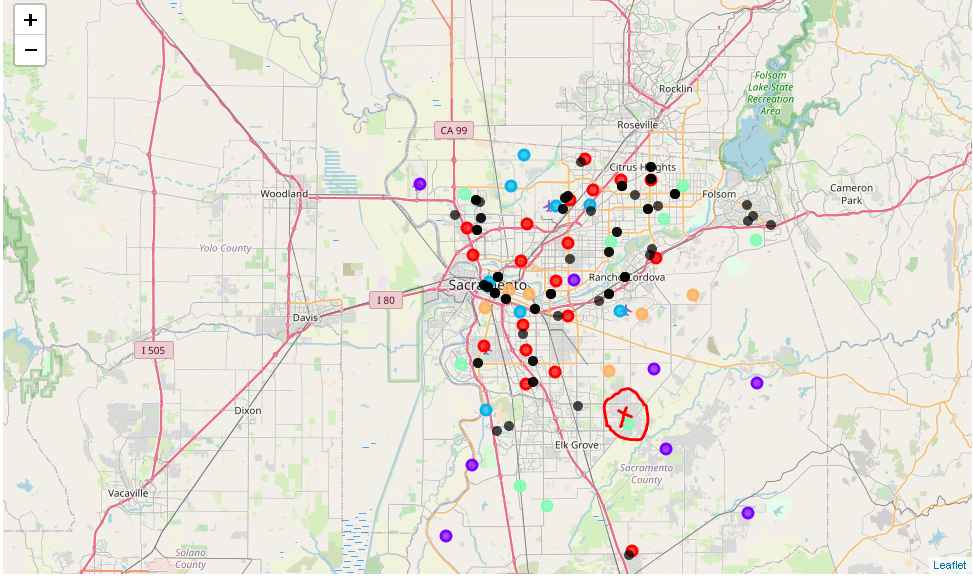